In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
import imageio
import os
from IPython.display import Image, display
import time
from scipy.stats import gaussian_kde
from statistics import mean
import statistics
import random

In [2]:
plotdir = 'plots/'

# load data

## parameters

In [3]:
Ms = 100 #number of importance samples
CHR = 18 
tCutoff = 'None'
samples = range(278*2)

## estimated dispersal rate

In [4]:
dispersal = np.load("data/SGDP_v1_annot_ne_%dM_%stCutoff_mle-dispersal.npy" %(Ms, tCutoff))
dispersal.reshape(2,2) #lat long covariance matrix

array([[2.00288269e+00, 6.70205515e-01],
       [1.04203660e-01, 8.07130111e-04]])

## estimated ancestor locations

for generations in

In [5]:
np.logspace(1,np.log10(1e4),10)

array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])

In [6]:
# get filenames
fnss_0 = []
for sample in samples:
    string = 'data/SGDP_v1_annot_ne_chr18' + '_*bps_%dM_%stCutoff_anc-locs_full-trees_%dsample.npy'%(Ms, tCutoff,sample)
    fns = [fn for fn in sorted(glob.iglob(string))]
    starts = [int(re.search('chr18_(.+?)-', fn).group(1)) for fn in fns]
    locus_order = np.argsort(starts)   
    fnss_0.append([fns[i] for i in locus_order])

# load locations
anc_locs_0 = []
for i,fns in enumerate(fnss_0):
    anc_loc = [np.squeeze(np.load(fn)) for fn in fns]
    anc_locs_0.append(anc_loc)
anc_locs_0 = np.array(anc_locs_0)
anc_locs_0 = np.swapaxes(anc_locs_0,0,1)
L, n, T, d = anc_locs_0.shape
L, n, T, d #11 times because includes time 0

(42, 556, 11, 2)

we later added a few deeper time points

In [7]:
np.logspace(np.log10(1e4),np.log10(1e5),5)[1:]

array([ 17782.79410039,  31622.77660168,  56234.13251903, 100000.        ])

In [8]:
# get filenames
fnss_10000 = []
for sample in samples:
    string = 'data/SGDP_v1_annot_ne_chr18' + '_*bps_%dM_10000+_generation_%stCutoff_anc-locs_full-trees_%dsample.npy'%(Ms, tCutoff,sample)
    fns = [fn for fn in sorted(glob.iglob(string))]
    starts = [int(re.search('chr18_(.+?)-', fn).group(1)) for fn in fns]
    locus_order = np.argsort(starts)
    fnss_10000.append([fns[i] for i in locus_order])

# load locations
anc_locs_10000 = []
for i,fns in enumerate(fnss_10000):
    anc_loc = [np.squeeze(np.load(fn)) for fn in fns]    
    anc_locs_10000.append(anc_loc)
anc_locs_10000 = np.array(anc_locs_10000)
anc_locs_10000 = np.swapaxes(anc_locs_10000,0,1)
anc_locs_10000 = anc_locs_10000[:, :, 1:, :] #exclude time 1e4
L, n, T, d = anc_locs_10000.shape
L, n, T, d #T=11 cuz include time 0

(42, 556, 4, 2)

merge

In [9]:
anc_locs = np.concatenate((anc_locs_0,anc_locs_10000),axis=2)
L, n, T, d = anc_locs.shape
L, n, T, d 

(42, 556, 15, 2)

ancestor times (in generations)

In [10]:
ancestor_times = np.append([0],np.logspace(1,np.log10(1e4),10))
ancestor_times = np.append(ancestor_times,np.logspace(np.log10(1e4),np.log10(1e5),5)[1:])
ancestor_times

array([0.00000000e+00, 1.00000000e+01, 2.15443469e+01, 4.64158883e+01,
       1.00000000e+02, 2.15443469e+02, 4.64158883e+02, 1.00000000e+03,
       2.15443469e+03, 4.64158883e+03, 1.00000000e+04, 1.77827941e+04,
       3.16227766e+04, 5.62341325e+04, 1.00000000e+05])

# comparison with Wohns et al 2022

## fig 4b

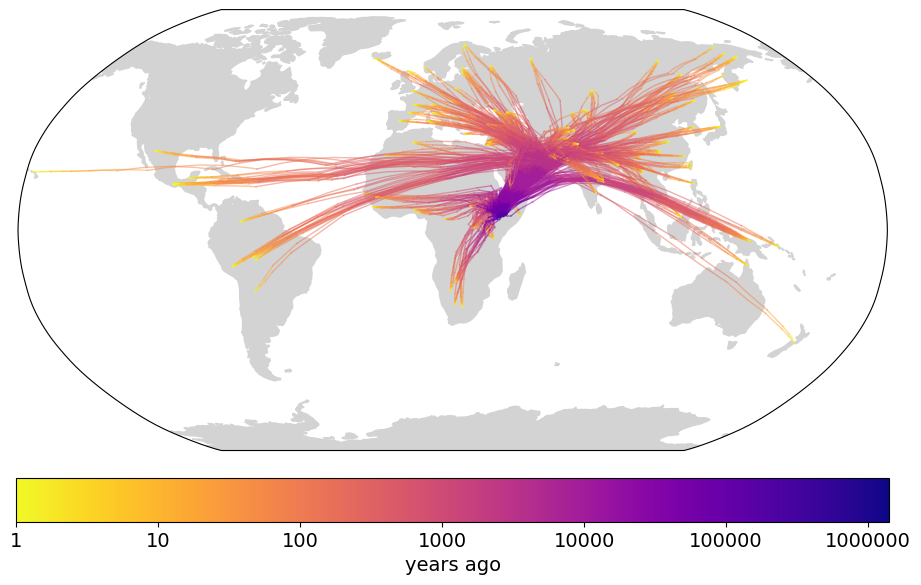

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in samples: #samples: #for each sample

    # get mean ancestor location at all times
    mean_locs = []
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(T-1): #exclude late times as numerical issues
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)

    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs) - 1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic) #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

## fig 4c

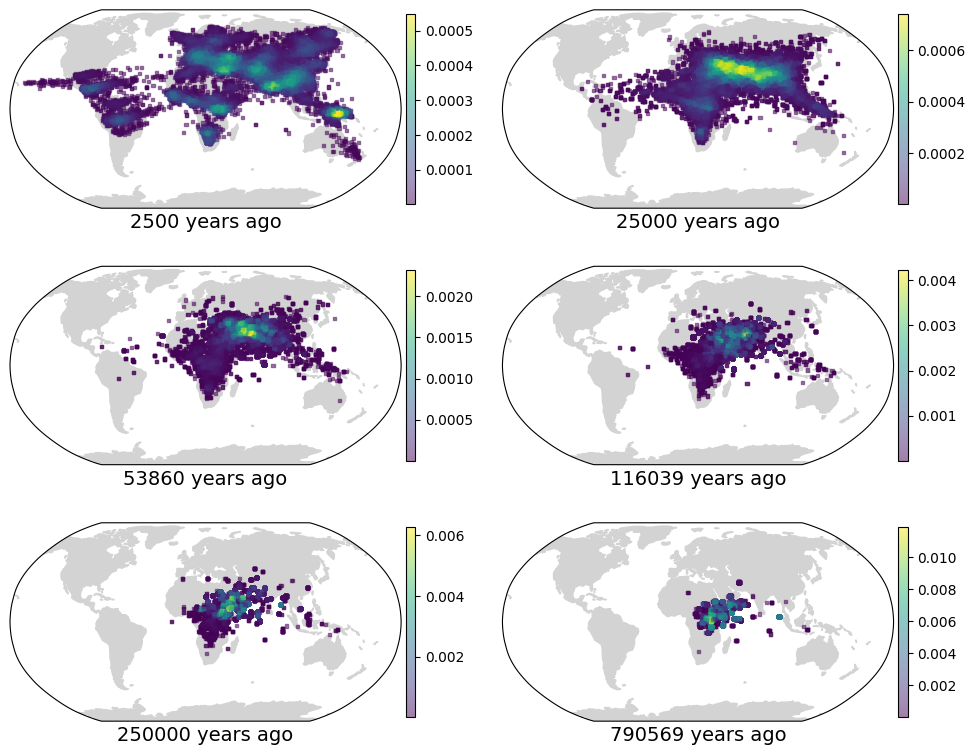

In [25]:
projection = ccrs.Robinson(central_longitude=20)
fig,axs = plt.subplots(3,2, subplot_kw={'projection': projection}, figsize=(10,8))
data_crs = ccrs.PlateCarree() #data supplied in lat/long

axs = axs.flatten()

for i,time_ix in enumerate([4,7,8,9,10,12]):

    # ax = axs[i] = plt.axes(projection=projection)
    axs[i].set_global()
    axs[i].add_feature(cfeature.LAND, color='lightgray')
    
    # all ancestors at given time
    all_locs = []
    for sample in range(n):
        locs = anc_locs[:, sample, time_ix]
        all_locs.append(locs)
    all_locs = np.vstack(all_locs)
    
    # estimate density
    xy = np.vstack([all_locs[:, 0], all_locs[:, 1]])
    kde = gaussian_kde(xy, bw_method=0.1) 
    z = kde(xy)

    # plot density
    sc = axs[i].scatter(all_locs[:, 0], all_locs[:, 1], c=z, s=5, marker='s', cmap='viridis', alpha=0.5, zorder=0, transform=data_crs)

    # color bar
    cbar = plt.colorbar(sc, orientation='vertical', pad=0.01, shrink=0.75, ax=axs[i])

    # # text
    axs[i].text(0.5, -0.1, '%d years ago' % int(ancestor_times[time_ix]*25), ha='center', fontsize=14, transform=axs[i].transAxes)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4c.png')
plt.show()

## supplementary video

In [26]:
# defining groups

# get group of each genome
ids = []
groups = []
with open('data/SGDP.poplabels',"rb") as f:
    next(f) #skip header
    for line in f:
        ids.append(line.strip().split(b' ')[0])
        groups.append(line.strip().split(b' ')[2])
    groups = [entry.decode('utf-8') for entry in groups]
    groups = [item for item in groups for _ in range(2)] #repeat for each genome in diploid
group_names, group_ixs = np.unique(groups, return_inverse=True)

# give each group a color
group_colors = ['yellow','red','pink','green','brown','purple','lightblue']

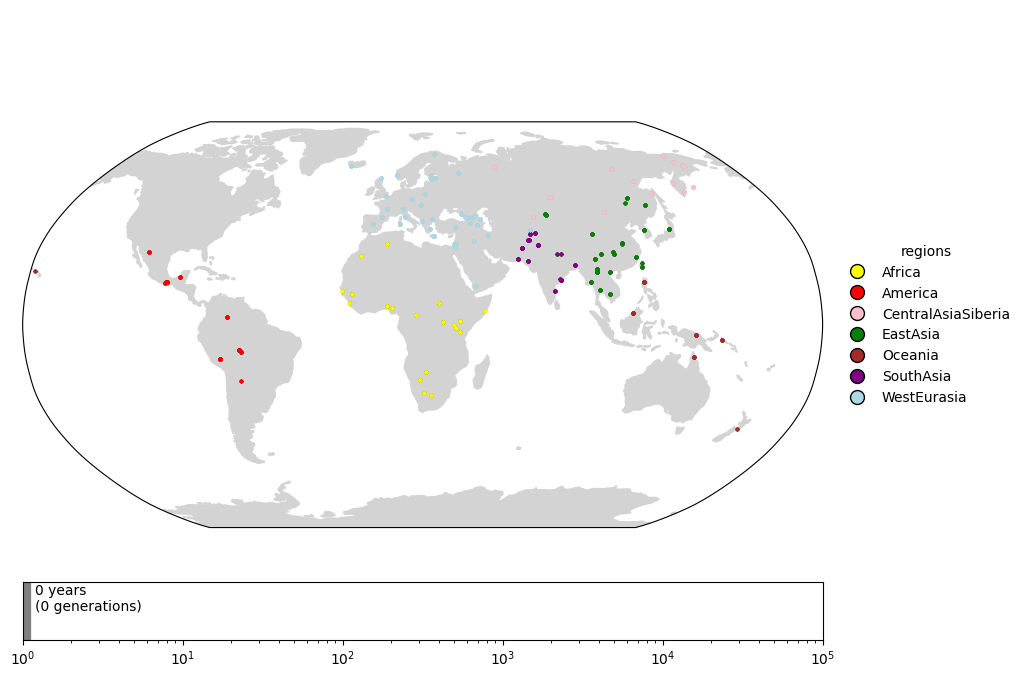

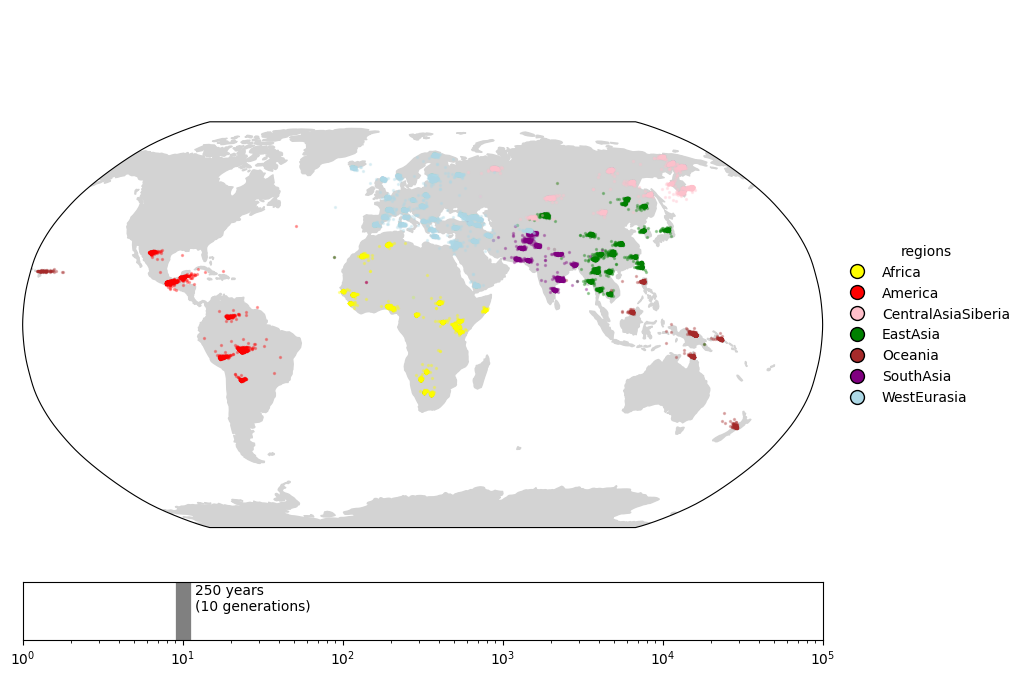

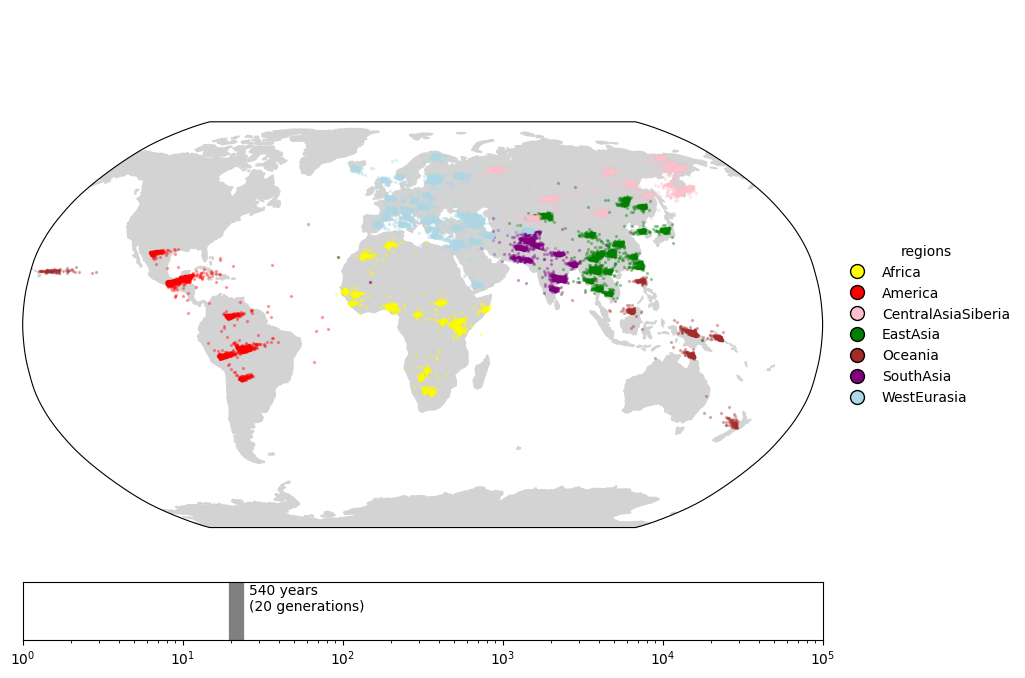

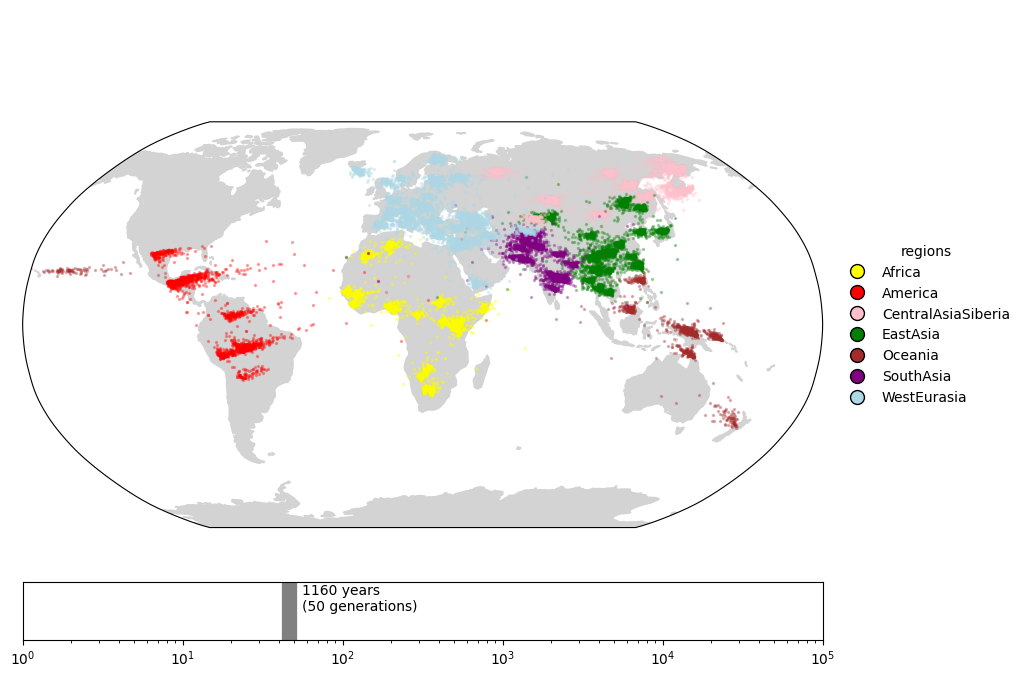

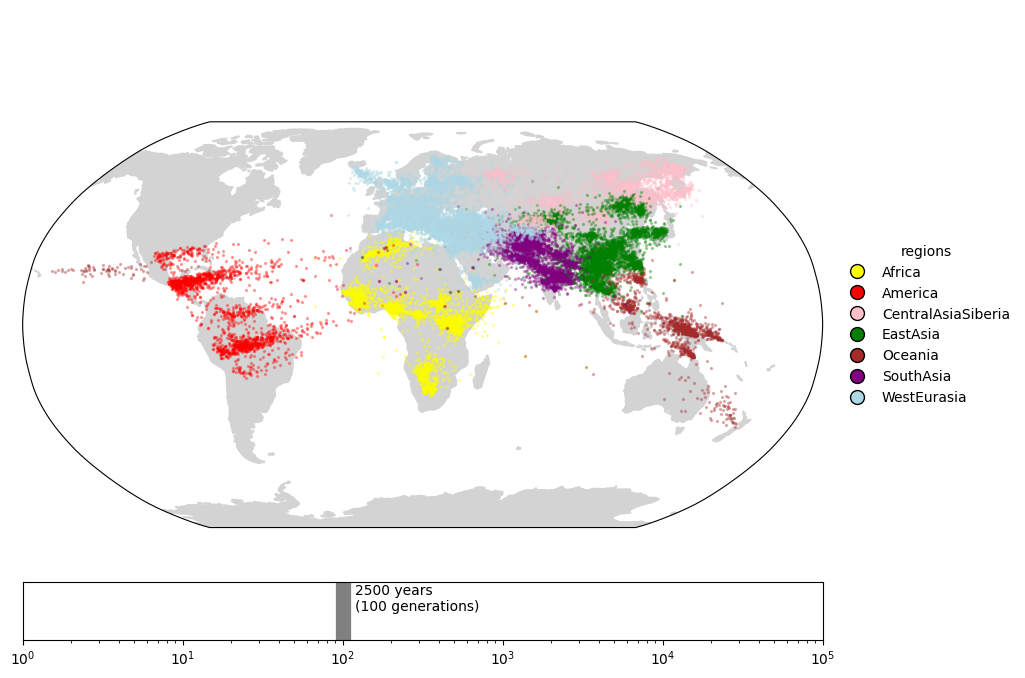

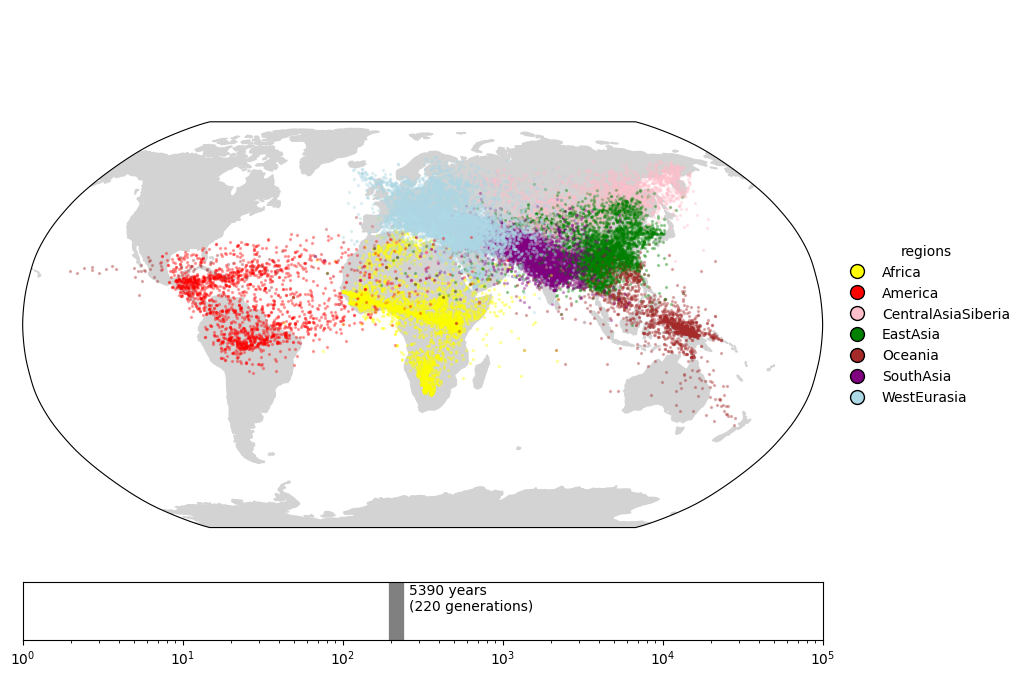

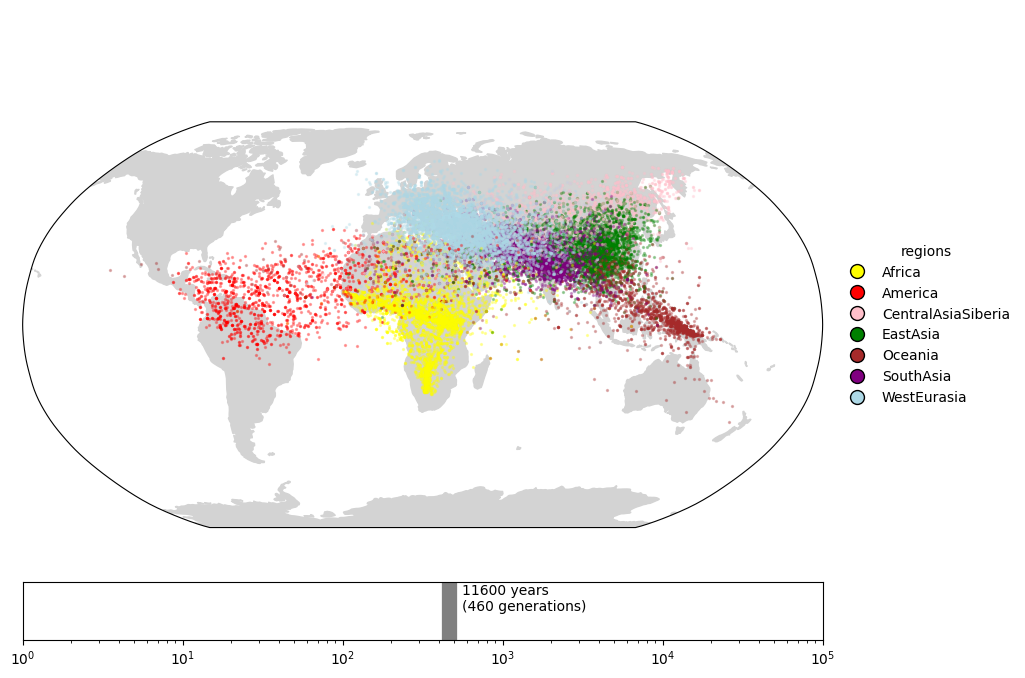

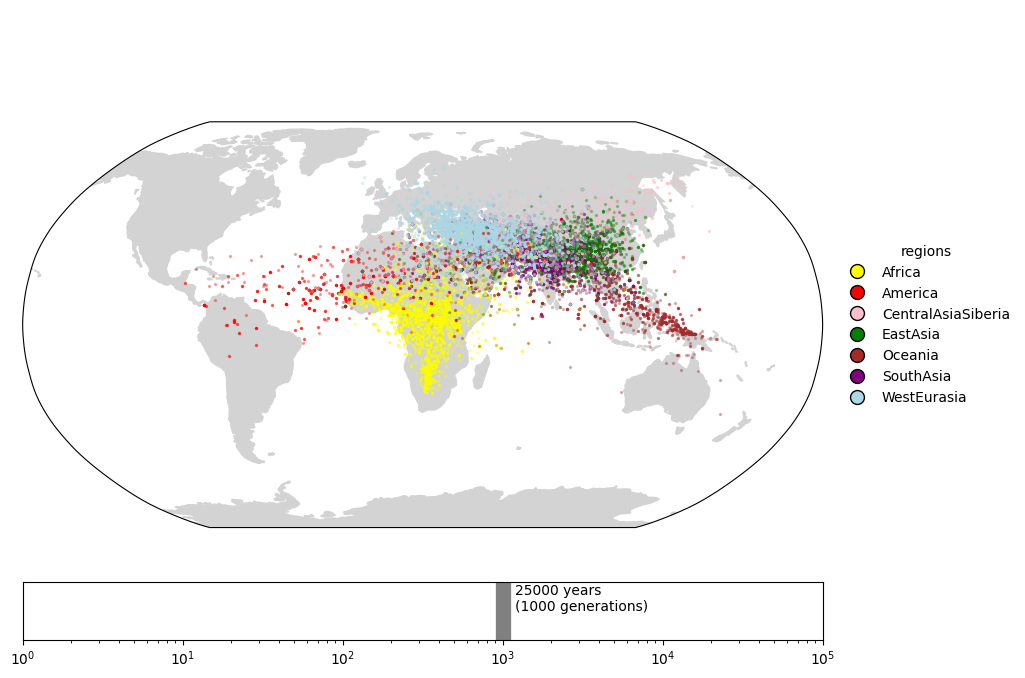

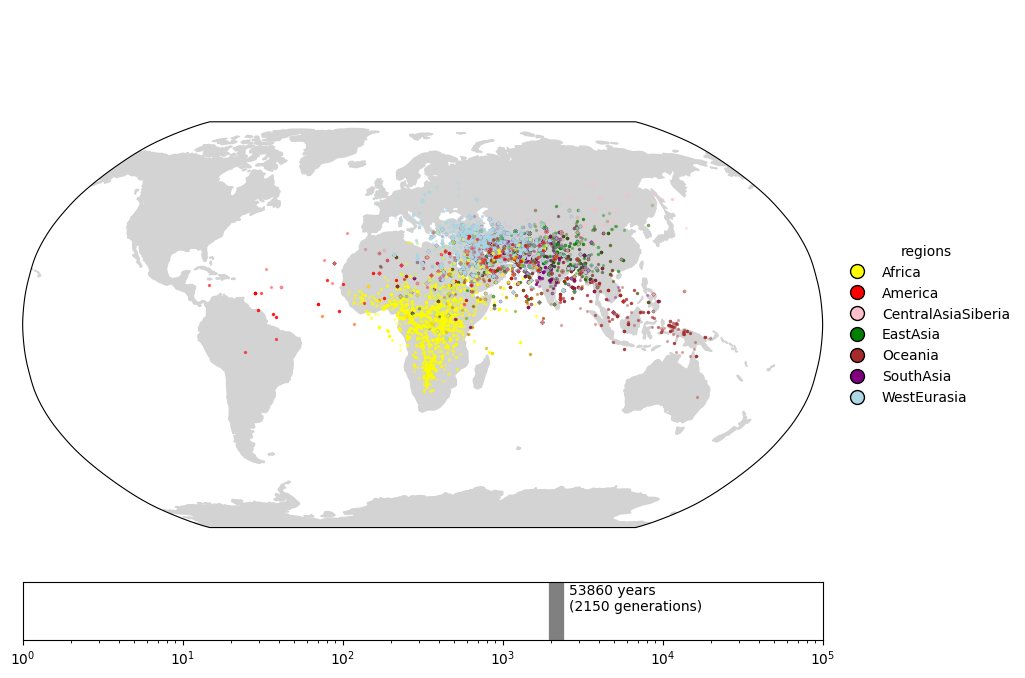

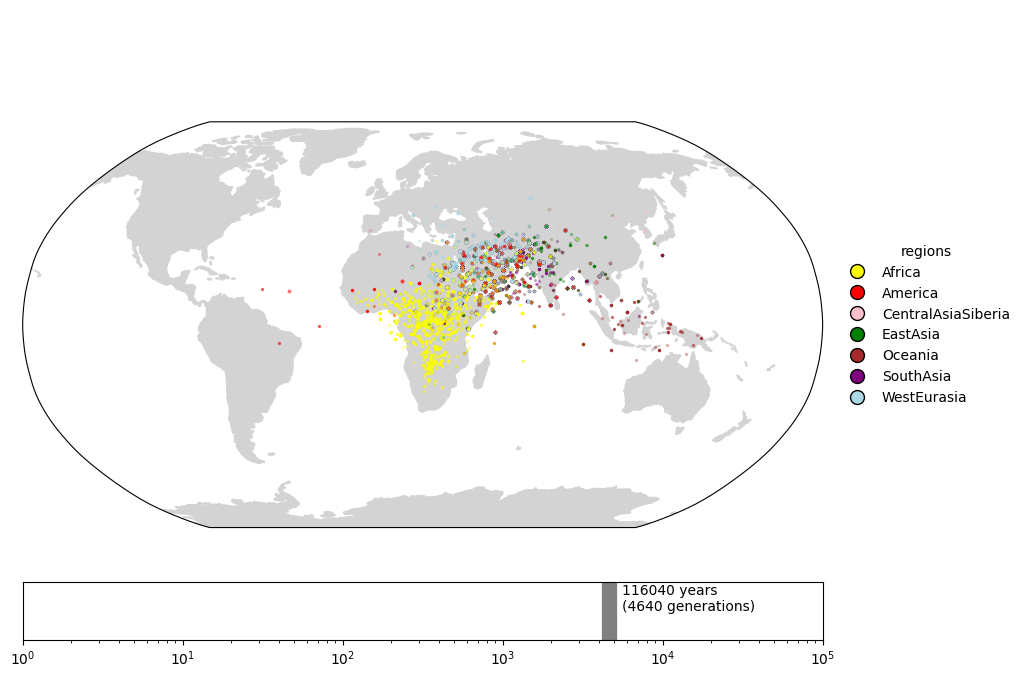

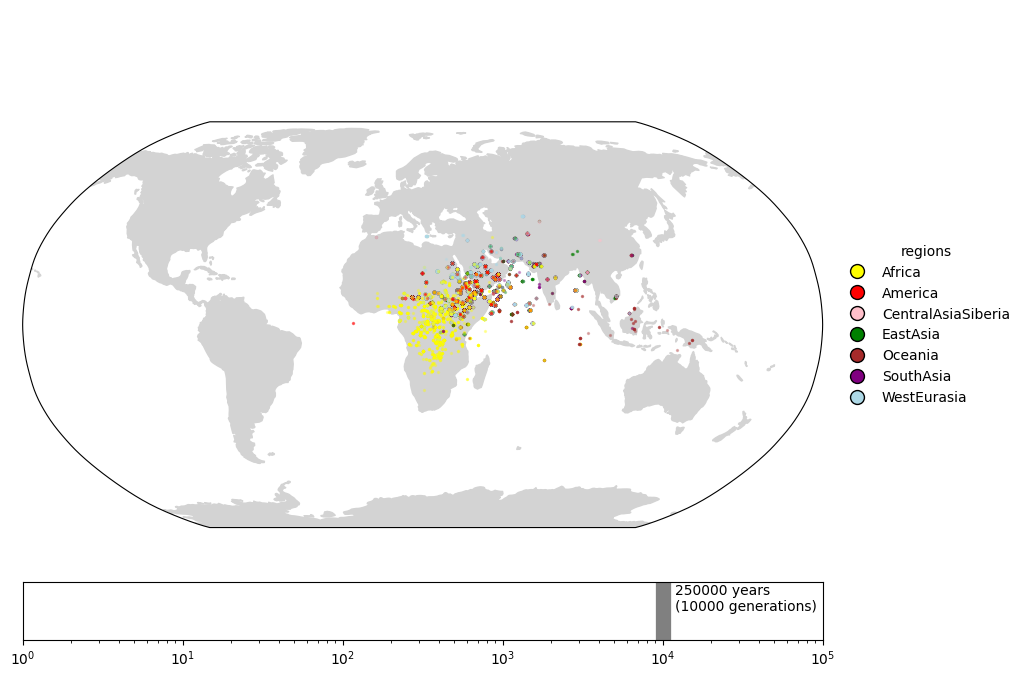

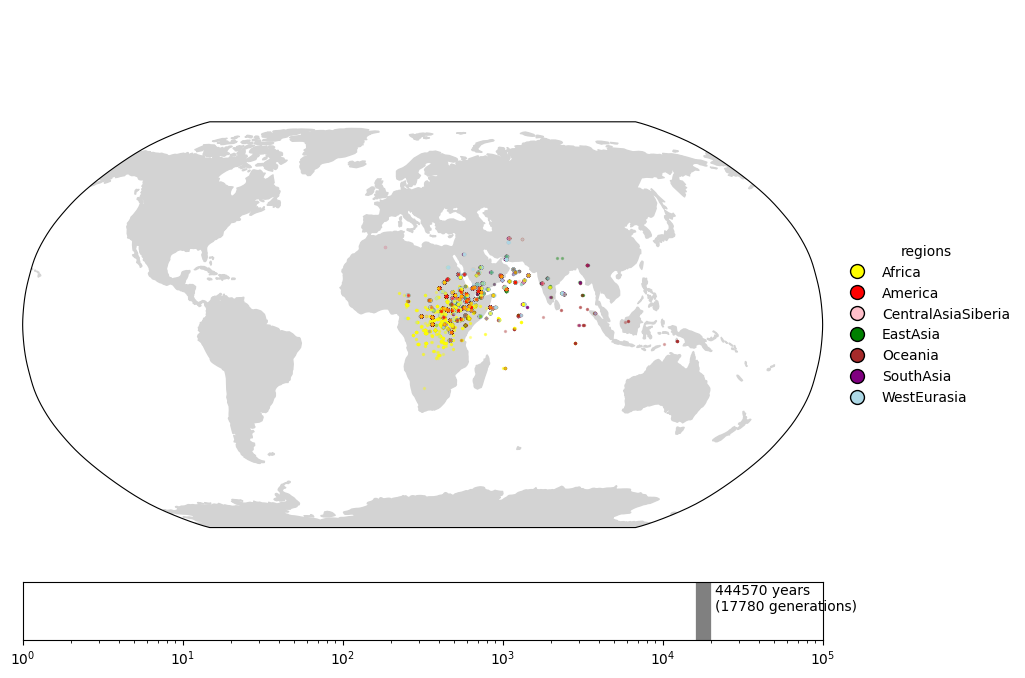

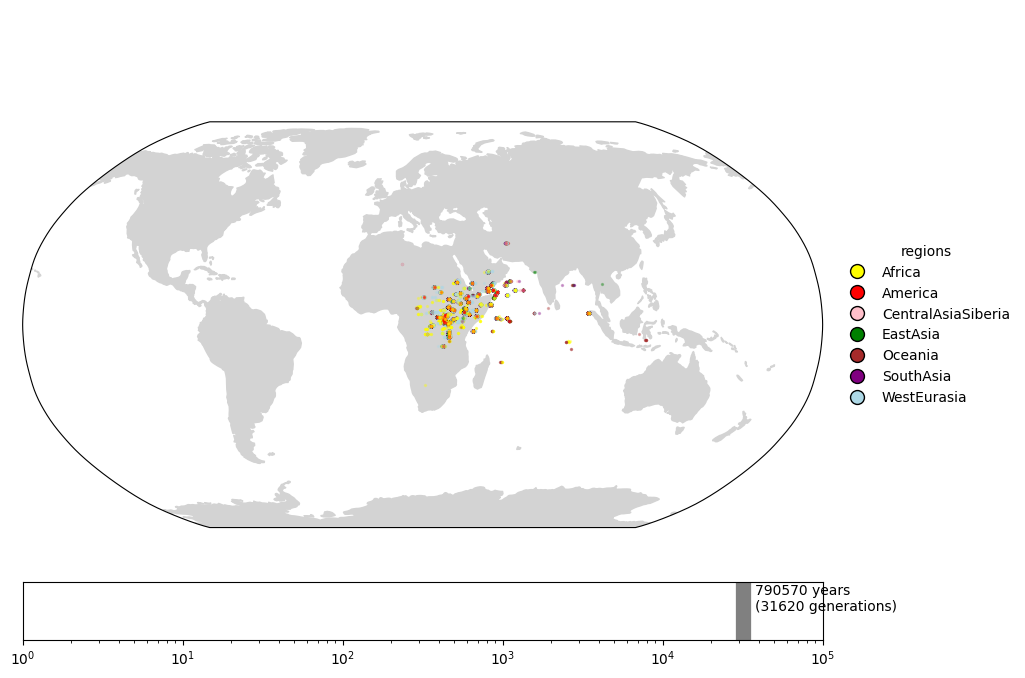

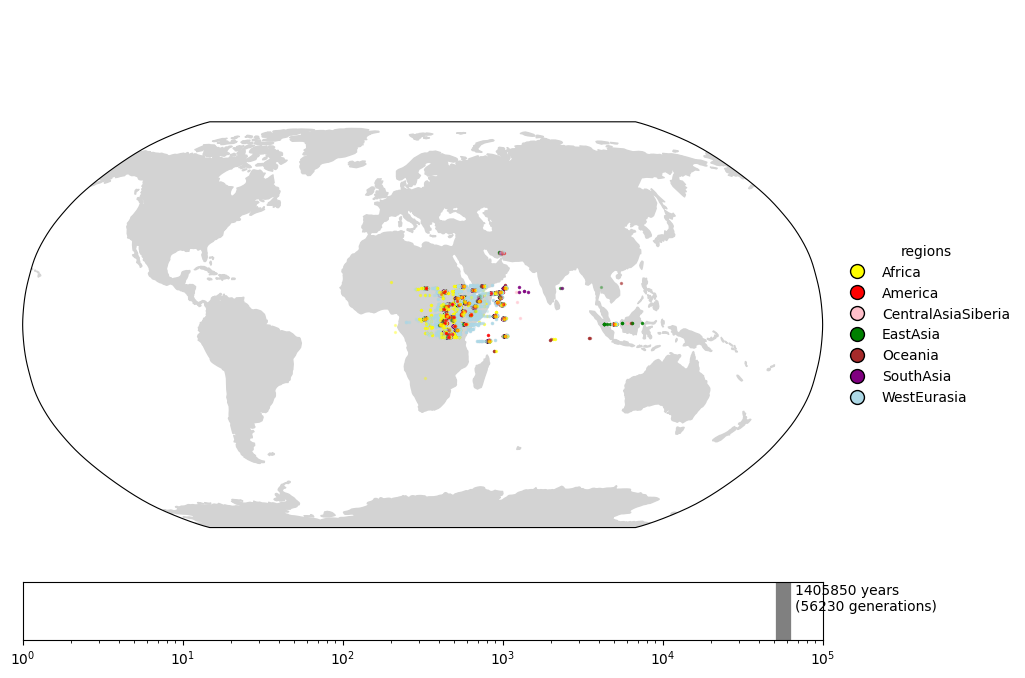

In [27]:
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long

for time_ix in range(T-1):

    fig, axs = plt.subplots(2, 1, figsize=(10, 7), height_ratios=[1, 0.1])
    ax = axs[0]
    ax.axis("off")
    dummy = axs[1]
    dummy.set_yticks([])
    
    ax = plt.axes(projection=projection)
    ax.set_global()
    ax.add_feature(cfeature.LAND, color='lightgray')
    
    # plot all ancestors of each sample
    for sample in range(n): 
        locs = anc_locs[:,sample,time_ix]
        ax.scatter(locs[:, 0], locs[:, 1], color=group_colors[group_ixs[sample]], s=2, alpha=0.3, zorder=0, transform=data_crs)

    # legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=i, 
                markeredgecolor='k', markersize=10, linestyle='') for i in group_colors]
    ax.legend(handles, group_names, title="regions", loc='center right', bbox_to_anchor=(1.25, 0.5), frameon=False)

    # timeline
    vline = dummy.axvline(ancestor_times[time_ix] if ancestor_times[time_ix]>0 else 1, linewidth=11, color="grey")
    dummy.set_xlim(1, ancestor_times[T-1])
    dummy.set_xscale("log")
    dummy.text(
            ancestor_times[time_ix]*1.2 if ancestor_times[time_ix]>0 else 1.2,
            0.5,
            str(int(np.round(ancestor_times[time_ix] * 25, -1)))
            + " years \n"
            + "("
            + str(int(np.round(ancestor_times[time_ix], -1)))
            + " generations)",
        )

    plt.subplots_adjust(left=0, bottom=0.1, right=0.8, top=1, wspace=0, hspace=0)
    # plt.tight_layout()
    plt.savefig(plotdir + 'group_%d.png' %time_ix)
    plt.show()

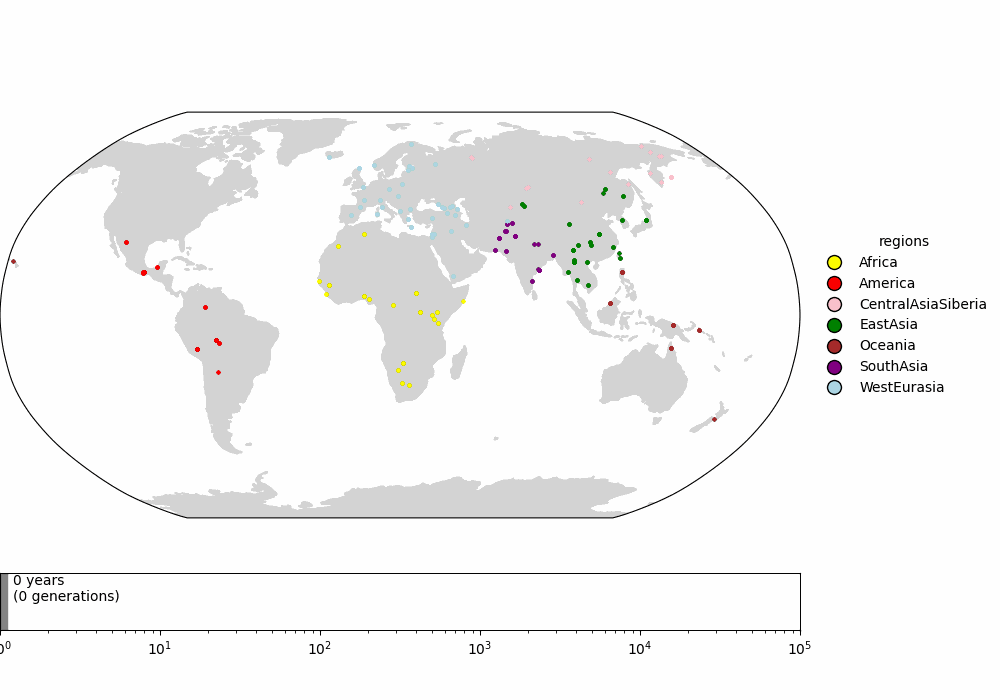

In [28]:
# make gif
frames = []
for time_ix in range(T-1):
    frames.append(imageio.v2.imread(plotdir + 'group_%d.png' %time_ix))
    
gifname = plotdir + 'group.gif'
imageio.mimsave(gifname, frames, duration=1000, loop=0)
display(Image(filename=gifname))

# comparison to Grundler et al 2025

## fig 2

In [29]:
from matplotlib.lines import Line2D

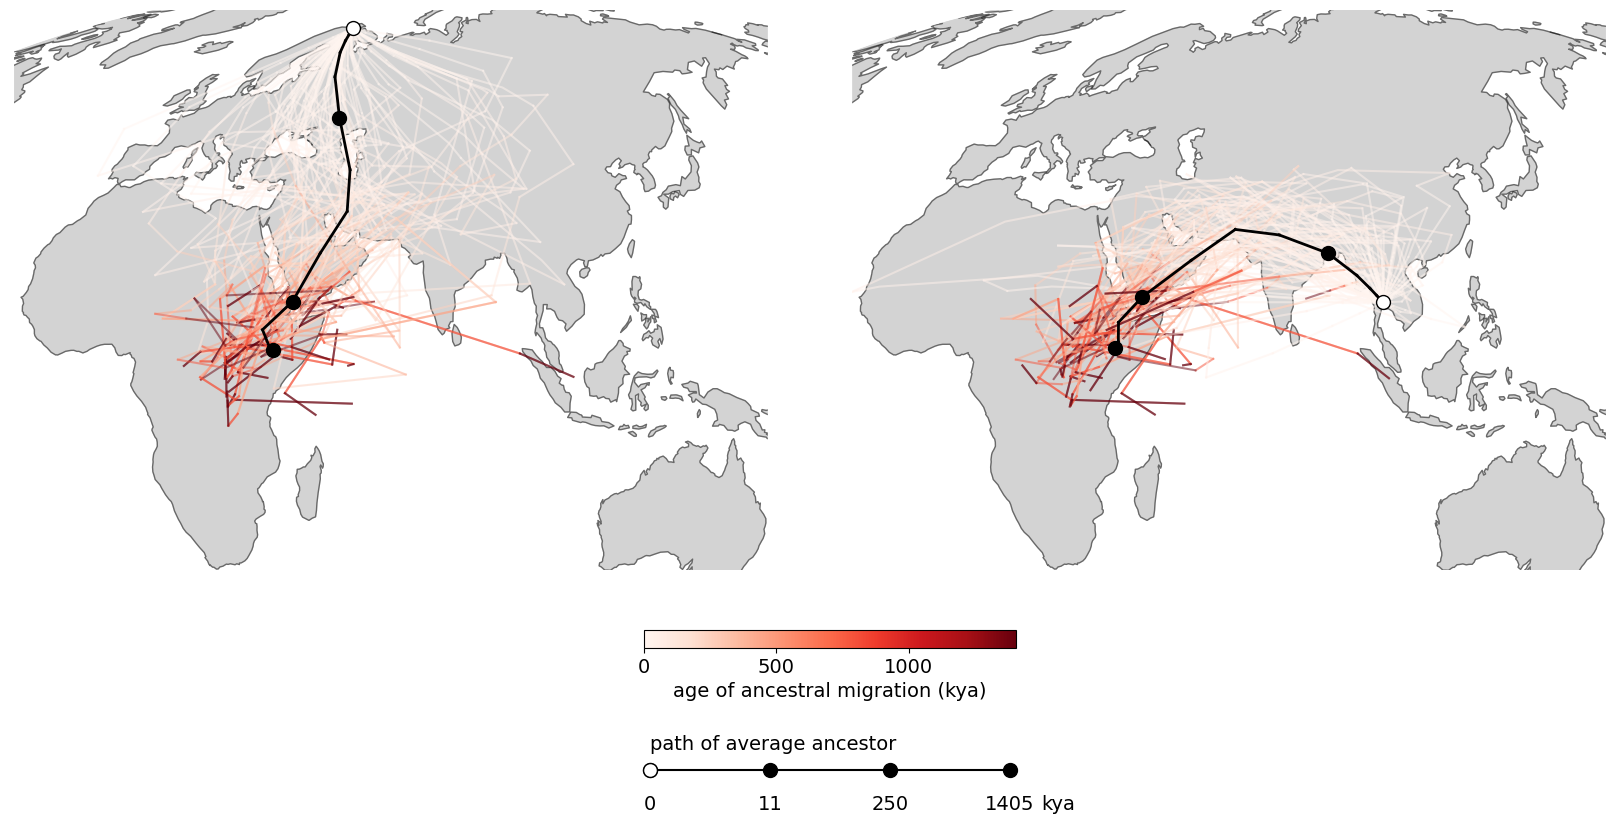

In [31]:
# projection = ccrs.Robinson()
# projection = ccrs.Orthographic(central_longitude=60, central_latitude=0)
# projection = ccrs.NearsidePerspective(central_longitude=60, central_latitude=0, satellite_height=85785831)
# projection = ccrs.AlbersEqualArea(central_longitude=60, central_latitude=0, standard_parallels=(10))
projection = ccrs.Mollweide(central_longitude=90)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles

fig,axs = plt.subplots(1,2, figsize=(16,8), subplot_kw={'projection': projection, 'frameon':False})

for i,sample in enumerate([410, 236]):

    ax = axs[i]
    ax.set_extent([-17, 150, -35, 75], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.coastlines(resolution='110m', alpha=0.5)
    cmap = plt.get_cmap("Reds")

    # plot individual loci trajectories
    for locus in range(L):
        for t in range(T - 2):
            color = cmap(ancestor_times[t+1] / ancestor_times[T-2])  # color by time
            for j in [sample,sample+1]: #both genomes
                x0,y0=anc_locs[locus, j, t, 0], anc_locs[locus, j, t, 1]
                x1,y1=anc_locs[locus, j, t+1, 0], anc_locs[locus, j, t+1, 1]
                ax.plot([x0,x1],[y0,y1], '-', color=color, lw=1.5, alpha=0.5, transform=geodetic) #great circles
                # ax.plot([x0,x1],[y0,y1], '-', color=color, lw=1.5, alpha=0.5, transform=data_crs) #straight lines
    
    # mean ancestor location at each time
    mean_locs = []
    for time_ix in range(T-1):
        mean_loc = np.mean(np.vstack([anc_locs[:, sample, time_ix],anc_locs[:, sample+1, time_ix]]), axis=0)
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)
    xys = projection.transform_points(geodetic, mean_locs[:, 0], mean_locs[:, 1])
    
    # plot mean ancestor trajectory
    for t in range(len(mean_locs)-1):
        x0,y0=mean_locs[t, 0], mean_locs[t, 1]
        x1,y1=mean_locs[t+1, 0], mean_locs[t+1, 1]
        ax.plot([x0,x1],[y0,y1], '-', color='k', lw=2, transform=geodetic)

    # plot a few mean ancestor points
    mean_times = [6,10,13]
    for t in mean_times:
        ax.plot(xys[t,0], xys[t,1], 'o', markersize=10, color='k')
        
    # plot sample location
    ax.plot(xys[0,0], xys[0,1], 'o', markersize=10, color = "white", markeredgecolor='k')

# colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=axs, orientation='horizontal', pad=0, shrink=0.3, location='bottom')
ts = [i*500 for i in range(3)]
cbar.set_ticks([i*1000/(ancestor_times[T-2]*25) for i in ts]) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('age of ancestral migration (kya)', fontsize=14)

# line legend
ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
x0 = 0.4
x1 = 0.625
y0 = 0.05
# xs = [x0] +  [x0 + np.log10(ancestor_times[i])/np.log10(ancestor_times[mean_times[-1]]) * (x1-x0) for i in mean_times]
mean_times = [0] + mean_times
xs = [x0 + i/(len(mean_times)-1) * (x1-x0) for i in range(len(mean_times))]
ax2.plot(xs,[y0 for _ in xs],'o-',c='k',markersize=10)
ax2.plot(x0,y0,'o',c='white',markersize=10, markeredgecolor='k')
ax2.set_ylim(0,1)
ax2.set_xlim(0,1)
for i,x in enumerate(xs):
    ax2.text(x,y0-0.05,int(ancestor_times[mean_times[i]]*25/1000),ha='center', fontsize=14)
ax2.text(x+0.03,y0-0.05,'kya', ha='center', fontsize=14)
ax2.text(x0,y0+0.025,'path of average ancestor', fontsize=14)
ax2.set_axis_off()

# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0.3, right=1, top=1, wspace=0.1, hspace=0)
plt.savefig(plotdir + 'grundler_2.png')
plt.show()

## fig 4

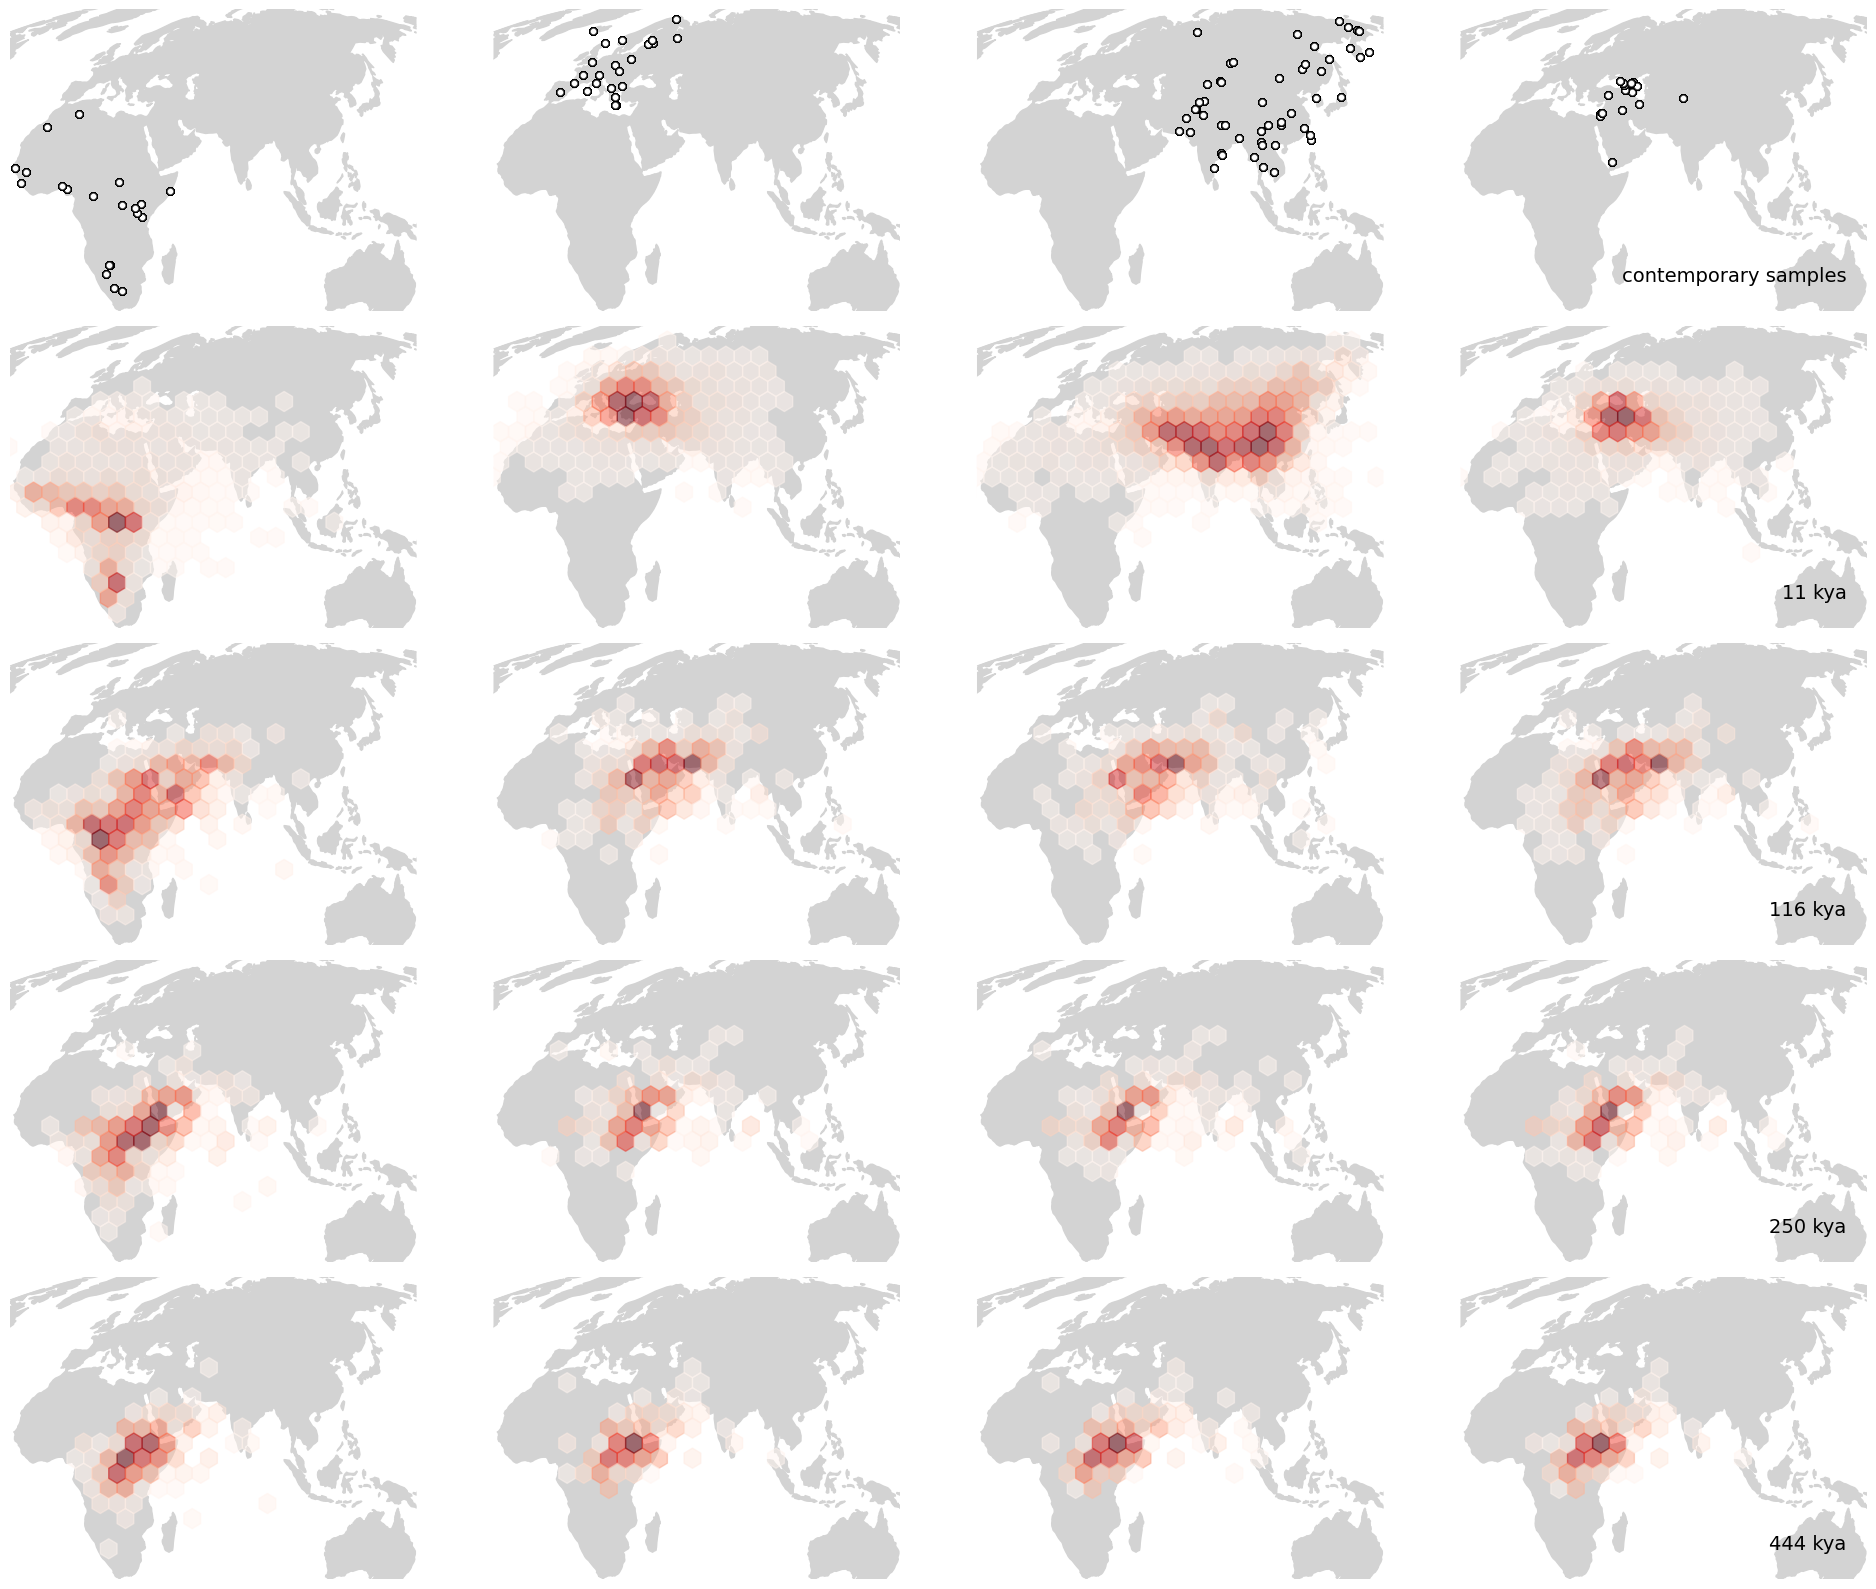

In [38]:
plot_groups = ['Africa', 'WestEurasia', ['EastAsia', 'CentralAsiaSiberia','SouthAsia'], 'WestEurasia']
plot_times = [0,6,9,10,11]

projection = ccrs.Mollweide(central_longitude=90)
data_crs = ccrs.PlateCarree() #data supplied in lat/long

xlims=np.array([-17,150])
ylims=np.array([-35,75])

cmap = plt.get_cmap("Reds")

fig, axs = plt.subplots(5,4, figsize=(20,16), subplot_kw={'projection': projection, 'frameon':False})

first = True
for j,gs in enumerate(plot_groups):

    group_samples = [i for i,name in enumerate(groups) if name in gs]
    if gs=='WestEurasia':
        if first==True:
            group_samples = [i for i in group_samples if anc_locs[0, i, 0, 0]<30 or anc_locs[0, i, 0, 1]>50] #"europe"
            first=False
        else:
            group_samples = [i for i in group_samples if anc_locs[0, i, 0, 0]>30 and anc_locs[0, i, 0, 1]<50] #"middle east"
    
    for i,ax in enumerate(axs[:,j]):
        
        ax.add_feature(cfeature.LAND, color='lightgray')
    
        # locations of all ancestors of all samples in group at this time
        all_locs = []
        for sample in group_samples:
            all_locs.append(anc_locs[:, sample, plot_times[i]])
        all_locs = np.vstack(all_locs) 

        if i==0:
            ax.plot(all_locs[:,0], all_locs[:,1], 'o', c='white', markeredgecolor='k', markersize=5, alpha=0.5, transform=data_crs)
        else:
            # histogram
            binlims = ax.projection.transform_points(data_crs, xlims, ylims) 
            # ax.hexbin(x=all_locs[:,0], y=all_locs[:,1], transform=data_crs, cmap=cmap, gridsize=[30,10], alpha=0.5, extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]])
            ax.hexbin(x=all_locs[:,0], y=all_locs[:,1], transform=data_crs, cmap=cmap, gridsize=[30,10], alpha=0.5, extent=[binlims[0,0]*1.5, binlims[1,0]*2.5, binlims[0,1], binlims[1,1]], mincnt=1)
        
        ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], crs=data_crs)

        if j==3:
            if i==0:
                text = 'contemporary samples'
            else:
                text = '%d kya' %int(ancestor_times[plot_times[i]]*25/1000)
            ax.text(0.95,0.1,text,transform = ax.transAxes, ha='right', fontsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'grundler_4.png')
plt.show()

# supplementary

## shift the origin over the Pacific

In [11]:
# get filenames
fnss_0_shifted = []
for sample in samples:
    string = 'data/SGDP_v1_annot_ne_chr18' + '_*bps_%dM_%stCutoff_anc-locs_full-trees_%dsample_projected.npy'%(Ms, tCutoff,sample)
    fns = [fn for fn in sorted(glob.iglob(string))]
    starts = [int(re.search('chr18_(.+?)-', fn).group(1)) for fn in fns]
    locus_order = np.argsort(starts)   
    fnss_0_shifted.append([fns[i] for i in locus_order])

# load locations
anc_locs_shifted = []
for i,fns in enumerate(fnss_0_shifted):
    anc_loc = [np.squeeze(np.load(fn)) for fn in fns]
    anc_locs_shifted.append(anc_loc)
anc_locs_shifted = np.array(anc_locs_shifted)
anc_locs_shifted = np.swapaxes(anc_locs_shifted,0,1)
L, n, T, d = anc_locs_shifted.shape
L, n, T, d #11 times because includes time 0

(42, 556, 13, 2)

In [12]:
ancestor_times_shifted = np.append([0],np.logspace(1,np.log10(1e4),10))
ancestor_times_shifted = np.append(ancestor_times_shifted,np.logspace(np.log10(1e4),np.log10(1e5),5)[1:3])
ancestor_times_shifted

array([0.00000000e+00, 1.00000000e+01, 2.15443469e+01, 4.64158883e+01,
       1.00000000e+02, 2.15443469e+02, 4.64158883e+02, 1.00000000e+03,
       2.15443469e+03, 4.64158883e+03, 1.00000000e+04, 1.77827941e+04,
       3.16227766e+04])

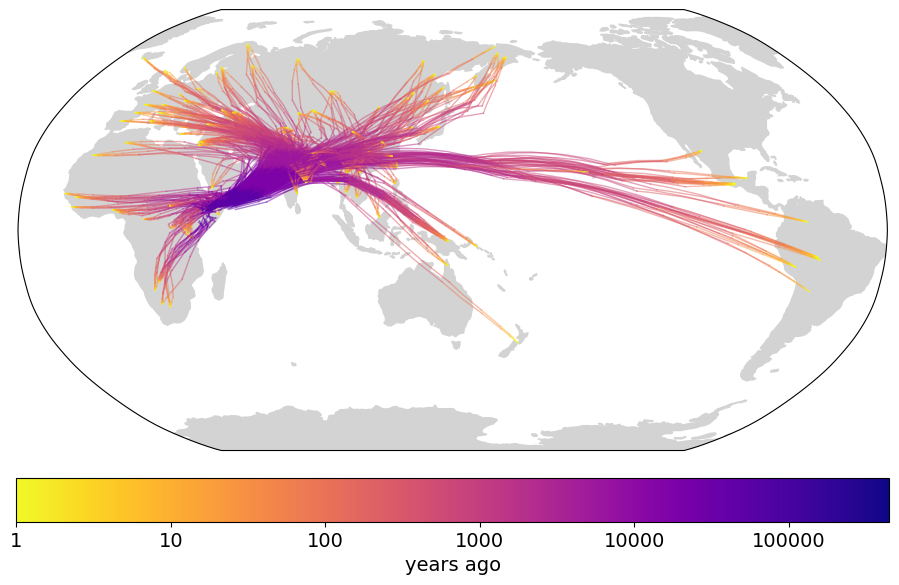

In [94]:
delta = -145
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=-delta)
data_crs = ccrs.PlateCarree(central_longitude=-delta) #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in samples: #samples: #for each sample

    # get mean ancestor location at all times
    mean_locs = []
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(T-1): #exclude late times as numerical issues
        locs = anc_locs_shifted[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)

    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs) - 1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]
        ax.plot([x0-delta,x1-delta], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic) #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(6)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times_shifted[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b_shifted.png')
plt.show()